# House Prices - Advanced Regression Techniques

Sergei Tsibikov, June 2024


Content:
* Data overview
* Data processing
  * Handling categorical columns
  * Handling missing values
  * Handling outliers
  * Box Cox transformation
  * Feature engineering
  * Implementing data processing 
* Machine Learning
  * GridSearchCV
  * StackedRegressor with ElasticNet, SVR and Catboost as meta learner

## Imports

In [3]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler

from scipy.stats import skew, kurtosis, boxcox
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
pd.options.display.max_columns = 100
pd.options.display.max_rows =  200
pd.options.display.max_info_rows = 1690785
pd.options.display.max_info_columns = 200
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.date_dayfirst = True
pd.options.mode.chained_assignment = None
pd.set_option("future.no_silent_downcasting", True)

ModuleNotFoundError: No module named 'catboost'

## Data overview

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df.head(-5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,1451,90,RL,60.00,9000,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,1974,1974,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,896,896,GasA,TA,Y,SBrkr,896,896,0,1792,0,0,2,2,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,32,45,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,136000
1451,1452,20,RL,78.00,9262,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,194.00,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1573,1573,GasA,Ex,Y,SBrkr,1578,0,0,1578,0,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,"2,008.00",Fin,3,840,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1452,1453,180,RM,35.00,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,5,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,80.00,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,Gd,Y,SBrkr,1072,0,0,1072,1,0,1,0,2,1,TA,5,Typ,0,NaN,Basment,"2,005.00",Fin,2,525,TA,TA,Y,0,28,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000
1453,1454,20,RL,90.00,17217,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,PConc,Gd,TA,

In [3]:
dtypes = df.dtypes.to_frame().reset_index()
dtypes.columns = ['col', 'dtype']
print('Df dtypes:')
dtypes.groupby('dtype').size()

Df dtypes:


dtype
int64      35
float64     3
object     43
dtype: int64

In [4]:
def na(df, percent = True, verbose = True):
    srs = df.isna().sum()[df.isna().sum() > 0]
    srs = srs.sort_values(ascending=False)
    if percent:
       if verbose:
           print('% of NaNs in df:')
       return srs / df.shape[0]
    else:
        if verbose:
           print('# of NaNs in df:')
        return srs

na(df, False)

# of NaNs in df:


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

There is no point in removing the columns with a lot of nans for the following reasons:
* Removing the columns is usually associated with underreported data, which is not the case here. Few values in the pool column just means that there are few houses with pools.
* These features might still be important. For example, presence of fences on the property would positively reflect on its evaluation.

### Correlation

<Axes: >

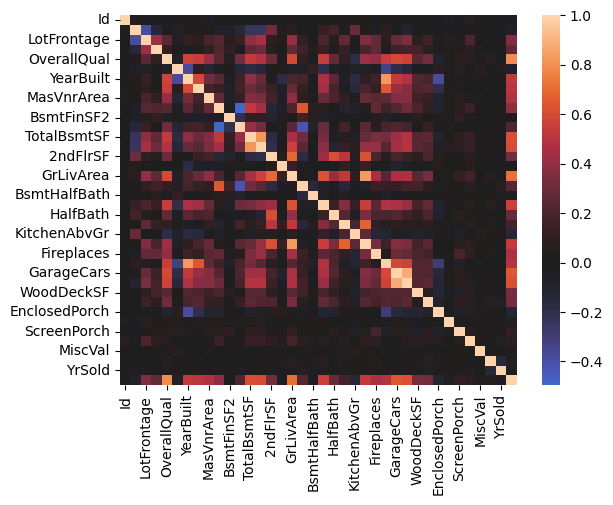

In [5]:
sns.heatmap(df.select_dtypes(exclude='object').corr(), center=0)

In [6]:
def get_corr_list(df, threshold = 0.6):
        corr = df.corr().unstack().to_frame().reset_index()
        corr.columns = ['var1', 'var2', 'corr']

        corr = corr[corr['var1'] != corr['var2']]
        
        corr['abs_corr'] = corr['corr'].abs()
        corr = corr.sort_values(by='abs_corr', ascending=False)
        corr = corr[corr['abs_corr'] > threshold]

        # we use this trick to hide mirrored rows
        corr = corr.iloc[::2]
        return corr

get_corr_list(df.select_dtypes(exclude='object'))

,var1,var2,corr,abs_corr
1052,GarageArea,GarageCars,0.88,0.88
956,GarageYrBlt,YearBuilt,0.83,0.83
890,TotRmsAbvGrd,GrLivArea,0.83,0.83
506,1stFlrSF,TotalBsmtSF,0.82,0.82
1410,SalePrice,OverallQual,0.79,0.79
645,GrLivArea,SalePrice,0.71,0.71
622,GrLivArea,2ndFlrSF,0.69,0.69
821,BedroomAbvGr,TotRmsAbvGrd,0.68,0.68
655,BsmtFullBath,BsmtFinSF1,0.65,0.65
957,GarageYrBlt,YearRemodAdd,0.64,0.64


In [7]:
__neighborhood = df.groupby('Neighborhood').agg({'Neighborhood' : 'size', 'SalePrice' : 'mean'})
__neighborhood.sort_values(by='SalePrice')

,Neighborhood,SalePrice
Neighborhood,,
MeadowV,17,"98,576.47"
IDOTRR,37,"100,123.78"
BrDale,16,"104,493.75"
BrkSide,58,"124,834.05"
Edwards,100,"128,219.70"
OldTown,113,"128,225.30"
Sawyer,74,"136,793.14"
Blueste,2,"137,500.00"
SWISU,25,"142,591.36"


There appears to be no outliers in mean sale price by neighborhood, which is good, and also kind of unusual.

### Data overview insights

The dataset includes information on:
* Building and its condition
* Public property connected to the house and its proximity, and the neighborhood
* Lot connected to the house
* Additional building components:
  * Basement
  * Garage
  * Porch
  * Pool

Opportunities for Feature Engineering:
* Multiplicative columns:
  * Fireplaces (Number of fireplaces) * FireplaceQu (Fireplace quality)
  * Heating * HeatingQC (Heating quality)
* Mean Encoding of Neighborhood columns, instead of One Hot
* Reform Condition1 and Condition2. They represent various conditions and should have been represented in a list-like structure. Instead of having these 2 columns, have one column for each condition.
* Dummy variables for years of financial crises (for date of sale) between 2006 and 2010:
  * The only applicable crisis is Great Recession: December 2007 – June 2009

# Data processing

## Handling categorical and quasi-numeric columns

Columns for encoding:
* All object columns but Neighborhood
* MSSubClass - a quasi-ordinal column

Not to be OHE encoded:
* Neighborhood - it will be mean encoded in FE part
* Condition1, Condition2 - according to FE opportunities
* OverallQual, OverallCond are true ordinal, so they stay as is

In [8]:
cat_cols = df.select_dtypes(include='object').columns.to_list() + ['MSSubClass']
cat_cols = [col for col in cat_cols if col not in ['Neighborhood', 'Condition1', 'Condition2', 'FireplaceQu']]
print(cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']


In [9]:
ohencoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohencoder.set_output(transform='pandas')

df_cats_encoded = ohencoder.fit_transform(df[cat_cols])
df_cats_encoded

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.

Keep in mind that now OHE treats nans as its own category, which is exactly what we want

In [10]:
# FireplaceQu is used later as an ordinal variable
df = pd.concat([df.drop(cat_cols, axis=1), df_cats_encoded], axis=1)
df

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,1,65.00,8450,CollgCr,Norm,Norm,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0,61,0,0,0,0,0,2,2008,208500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,80.00,9600,Veenker,Feedr,Norm,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,298,0,0,0,0,0,0,5,2007,181500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,68.00,11250,CollgCr,Norm,Norm,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0,42,0,0,0,0,0,9,2008,223500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,60.00,9550,Crawfor,Norm,Norm,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0,35,272,0,0,0,0,2,2006,140000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,84.00,14260,NoRidge,Norm,Norm,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,192,84,0,0,0,0,0,12,2008,250000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.00,7917,Gilbert,Norm,Norm,6,5,1999,2000,0.00,0,0,953,953

## Handling missing values

In [11]:
na(df, False)

# of NaNs in df:


FireplaceQu    690
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

Note that most of missing values are gone due to OHE encoding

In [12]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [13]:
df.select_dtypes(exclude='object').corr()['GarageYrBlt'].sort_values(ascending=False)

GarageYrBlt        1.00
YearBuilt          0.83
Foundation_PConc   0.66
YearRemodAdd       0.64
GarageCars         0.59
                   ... 
ExterCond_Po        NaN
GarageType_nan      NaN
GarageFinish_nan    NaN
GarageQual_nan      NaN
GarageCond_nan      NaN
Name: GarageYrBlt, Length: 231, dtype: float64

In [14]:
df.loc[df['GarageYrBlt'].isna(), 'GarageYrBlt'] = df.loc[df['GarageYrBlt'].isna(), 'YearBuilt']

In [15]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

Missing values imputation strategies:
* LotFrontage - fill 0 based on description
* GarageYrBlt - fill with respective values from YearBuilt since they have the most correlation, and it makes sense based on description
* MasVnrArea - fill 0 based on descriptionHandling outliers

## Handling outliers

Detecting outliers with no relation to other variables is viable, but pretty basic. Instead, I will check for outliers 

In [16]:
df.select_dtypes(exclude='object').corr()['SalePrice'].sort_values(ascending=False)

SalePrice           1.00
OverallQual         0.79
GrLivArea           0.71
GarageCars          0.64
GarageArea          0.62
                    ... 
MasVnrType_nan     -0.37
GarageFinish_Unf   -0.41
BsmtQual_TA        -0.45
KitchenQual_TA     -0.52
ExterQual_TA       -0.59
Name: SalePrice, Length: 231, dtype: float64

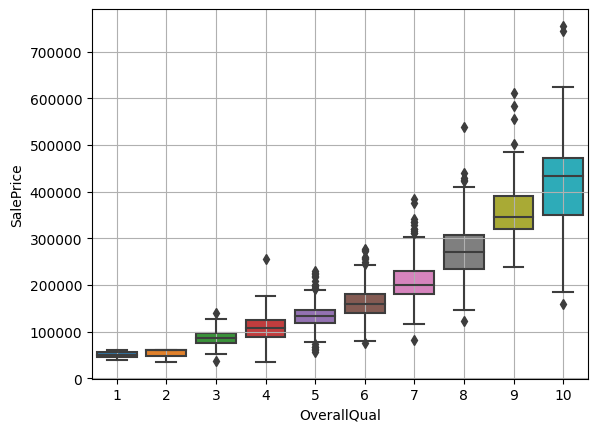

In [17]:
sns.boxplot(df, y='SalePrice', x='OverallQual')
plt.grid()

Outliers can be seen for quality levels of 4, 8 and 10.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

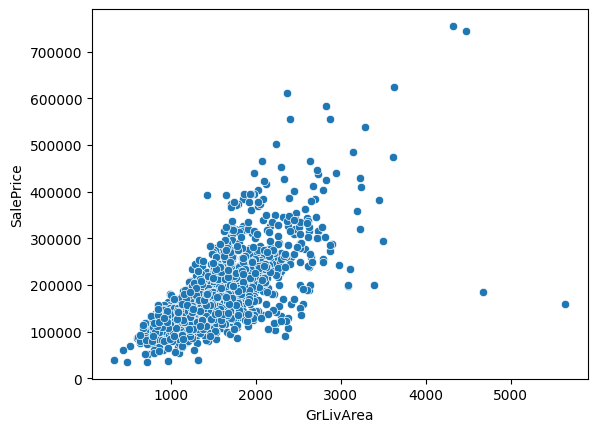

In [18]:
sns.scatterplot(df, y='SalePrice', x='GrLivArea')

Outliers are seen for GrLivArea > 4 000 and SalePrice < 30 000

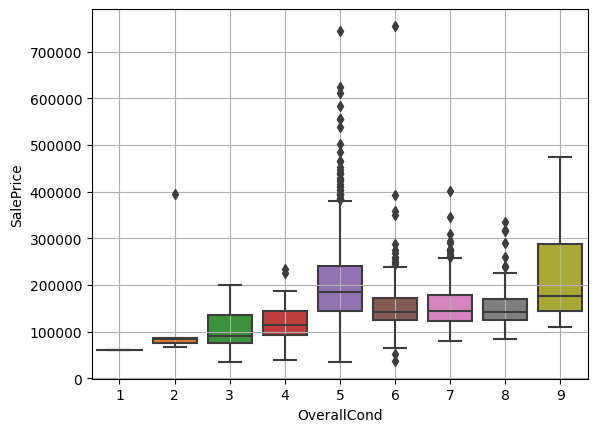

In [19]:
sns.boxplot(df, y='SalePrice', x='OverallCond')
plt.grid()

Even though OverallCond isnt in the list of top correlated features with SalePrice, this variable's information is pretty broad to warrant its use.

Outliers can be seen for OverallCond 2 and 6.

Lets take a look at all the rows identified as outliers

In [20]:
outliers = pd.concat([
    df[(df['OverallQual'] == 4) & (df['SalePrice'] > 2e5)],
    df[(df['OverallQual'] == 8) & (df['SalePrice'] > 5e5)],
    df[(df['OverallQual'] == 10) & (df['SalePrice'] > 7e5)],
    df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 3e5)],
    df[(df['OverallCond'] == 2) & (df['SalePrice'] > 3e5)],
    df[(df['OverallCond'] == 6) & (df['SalePrice'] > 7e5)]
    ]).sort_index().drop_duplicates()

outliers

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
378,379,88.00,11394,StoneBr,Norm,Norm,9,2,2010,2010,350.00,1445,0,411,1856,1856,0,0,1856,1,0,1,1,1,1,8,1,Ex,"2,010.00",3,834,113,0,0,0,0,0,0,6,2010,394432,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
457,458,0.00,53227,ClearCr,Norm,Norm,4,6,1954,1994,0.00,1116,0,248,1364,1663,0,0,1663,1,0,1,0,2,1,6,2,Gd,"1,954.00",2,529,224,137,0,0,0,0,0,3,2008,256000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
523,524,130.00,40094,Edwards,PosN,PosN,10,5,2007,2008,762.00,2260,0,878,3138,3138,1538,0,4676,1,0,3,1,3,1,11,1,Gd,"2,007.00",3,884,208,406,0,0,0,0,0,10,2007,184750,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
691,692,104.00,21535,NoRidge,Norm,Norm,10,6,1994,1995,"1,170.00",1455,0,989,2444,2444,1872,0,4316,0,1,3,1,4,1,10,2,Ex,"1,994.00",3,832,382,50,0,0,0,0,0,1,2007,755000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
769,770,47.00,53504,StoneBr,Norm,Norm,8,5,2003,2003,603.00,1416,0,234,1650,1690,1589,0,3279,1,0,3,1,4,1,12,1,Gd,"2,003.00",3,841,503,36,0,0,210,0,0,6,2010,538000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1182,1183,160.00,15623,NoRidge,Norm,Norm,10,5,1996,1996,0.00,2096,0,300,2396,2411,2065,0,4476,1,0,3,1,4,1,10,2,TA,"1,996.00",3,813,171,78,0,0,0,555,0,7,2007,745000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.

In [21]:
df = df.drop(outliers.index)
df.shape

(1453, 235)

## Power transformation - skew, kurtosis and Box Cox

Lets first look at skew, kurtosis of num. variables

In [22]:
skew_kurtosis_data = []

for col in df.select_dtypes(include='number').columns:
    srs = df[col].dropna()
    ln_srs = np.log1p(srs)
    skew_kurtosis_data.append({'name' : col,
    'normal_skew' : skew(srs),
    'ln_skew' : skew(ln_srs),
    'normal_kurtosis' : kurtosis(srs),
    'ln_kurtosis' : kurtosis(ln_srs)
})

skew_kurtosis_data = pd.DataFrame(skew_kurtosis_data)
skew_kurtosis_data.iloc[:, 1:] = skew_kurtosis_data.iloc[:, 1:].abs()
skew_kurtosis_data

,name,normal_skew,ln_skew,normal_kurtosis,ln_kurtosis
0,Id,0.00,1.79,1.20,4.03
1,LotFrontage,0.00,1.55,1.96,0.62
2,LotArea,12.97,0.23,224.13,4.79
3,OverallQual,0.18,0.62,0.06,2.09
4,OverallCond,0.71,0.20,1.06,3.12
...,...,...,...,...,...
226,MSSubClass_90,5.00,5.00,22.98,22.98
227,MSSubClass_120,3.71,3.71,11.76,11.76
228,MSSubClass_160,4.48,4.48,18.11,18.11
229,MSSubClass_180,11.93,11.93,140.31,140.31


Even though this data is pretty insightful, there are a lot more transformations other than log. So, I employ Box Cox method and compute optimal boxcox lambdas for every column.

In [23]:
lambdas = []
for col in df.select_dtypes(exclude='object').columns:
    coef = boxcox(df[col] + 1)[1]
    lambdas.append({'name' : col, 'coef' : coef})

lambdas = pd.DataFrame(lambdas).set_index('name')

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:935: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2488: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)


In [24]:
uniques = df.nunique()

lambdas.loc[uniques[uniques >= 100].index]

,coef
Id,0.71
LotFrontage,0.76
LotArea,0.05
YearBuilt,21.96
MasVnrArea,-0.25
BsmtFinSF1,0.23
BsmtFinSF2,-1.51
BsmtUnfSF,0.47
TotalBsmtSF,0.81
1stFlrSF,0.00


I dont believe it is a good idea to transform binary or ordinal columns, so we focus only on columns with great number of unique values.

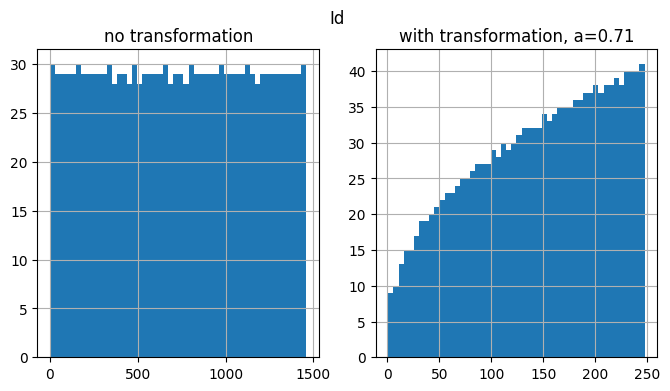

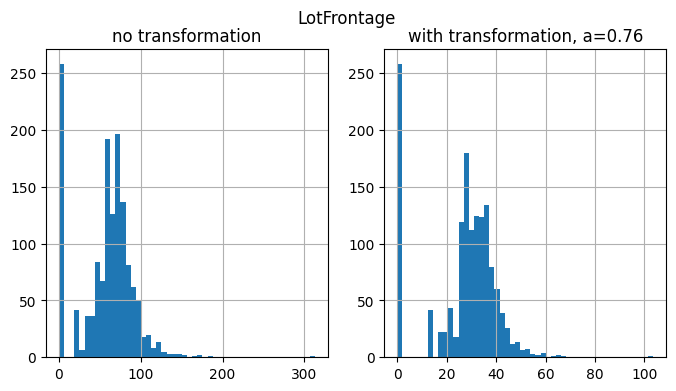

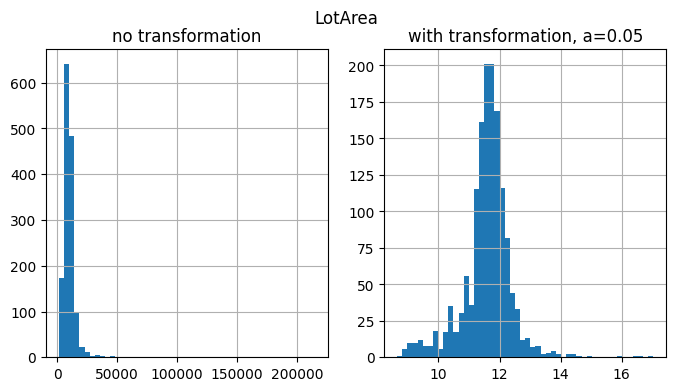

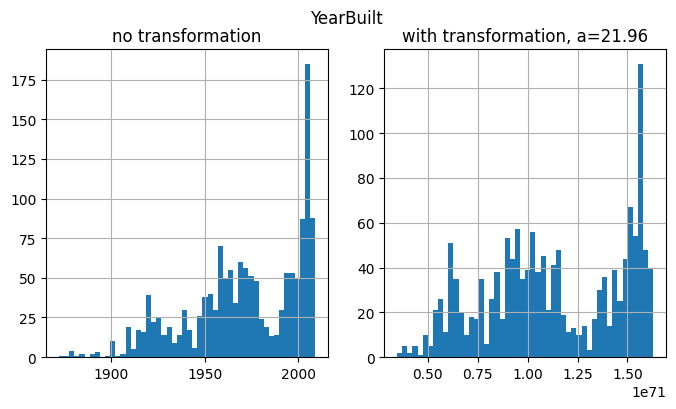

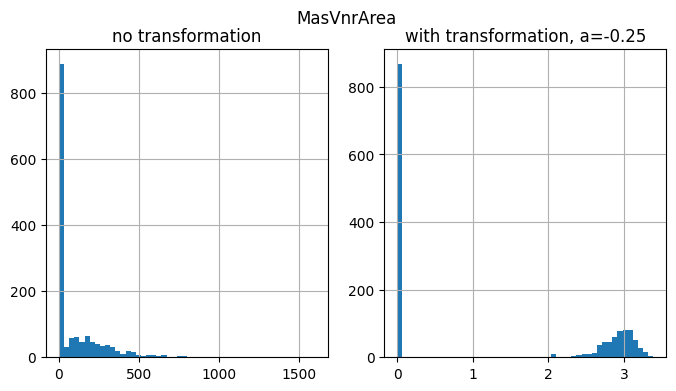

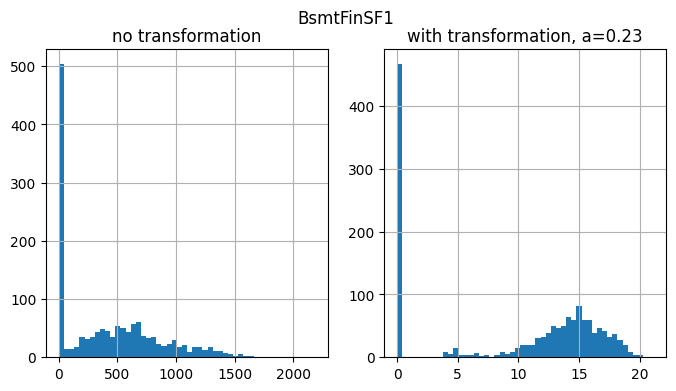

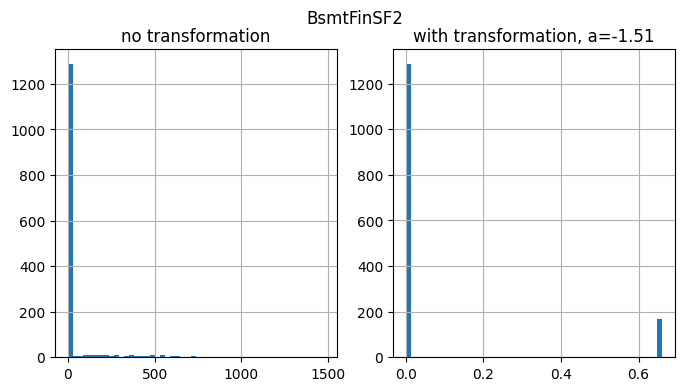

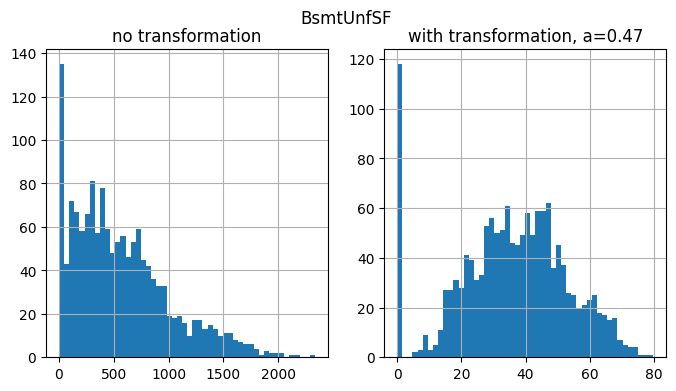

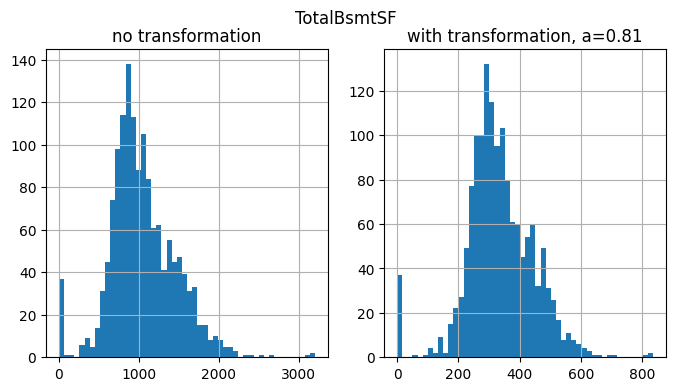

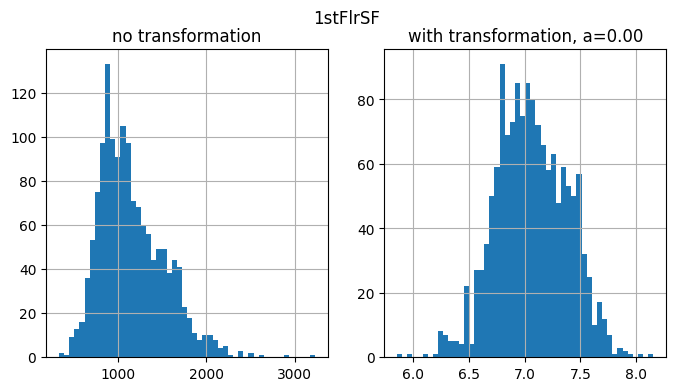

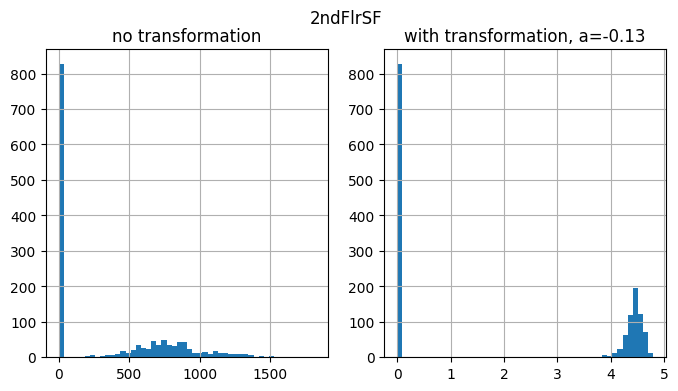

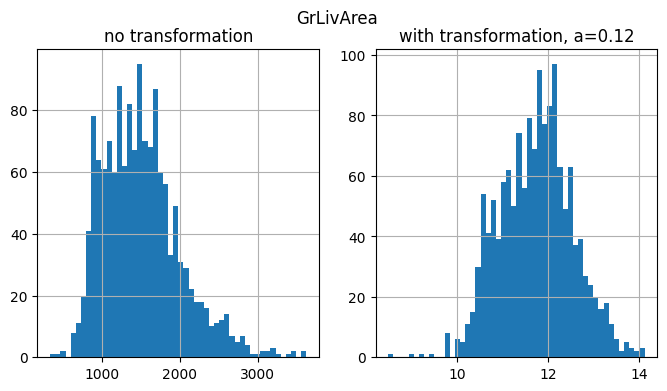

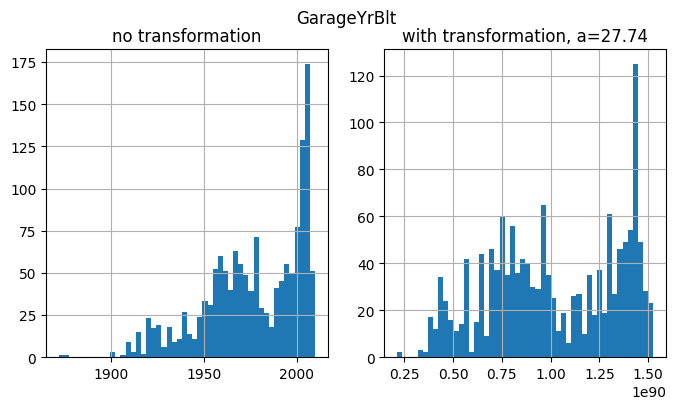

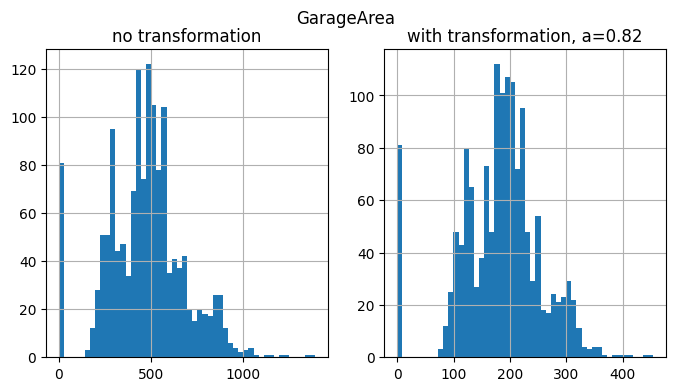

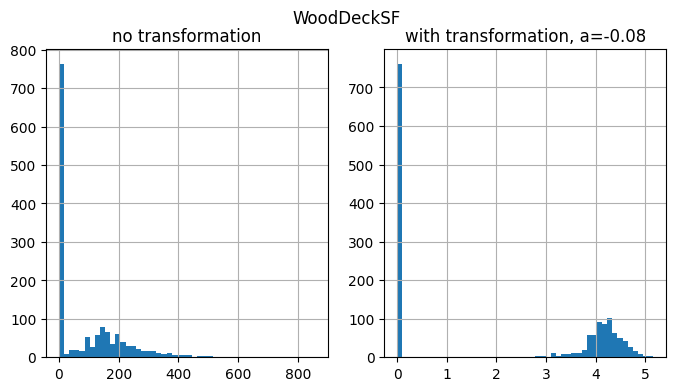

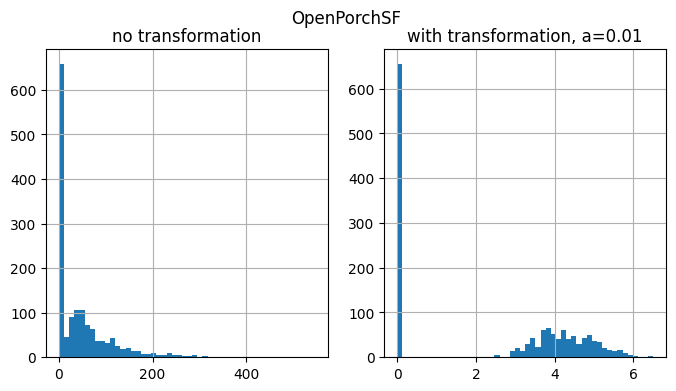

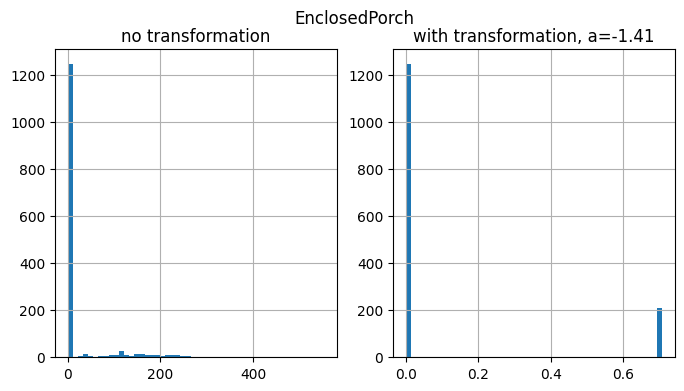

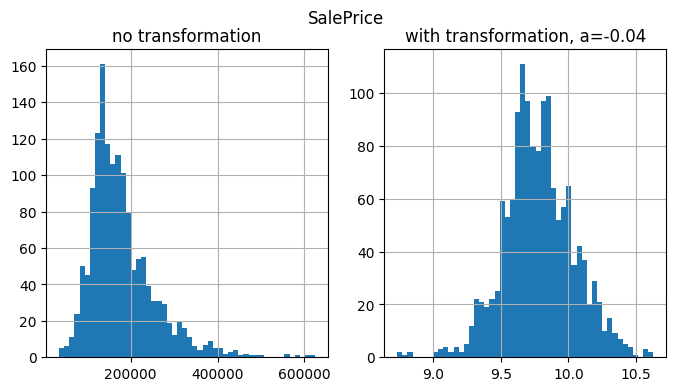

In [25]:
def lambda_comparison(col):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    df[col].hist(bins=50, ax=axs[0])
    axs[0].title.set_text('no transformation')
    
    _lambda = lambdas.loc[col].values[0]
    pd.Series(boxcox(df[col] + 1, _lambda)).hist(bins=50, ax=axs[1])
    axs[1].title.set_text(f'with transformation, a={_lambda:.2f}')

    fig.suptitle(col)
    plt.show()
    return


for col in lambdas.loc[uniques[uniques >= 100].index].index:
    lambda_comparison(col)

I will also not focus on id or time-related columns, and also the columns with lambda close to 1.

So, columns that will be transformed are:
* LotArea - log (lambda=0)
* MasVnrArea - log
* BsmtFinSF1 - log
* BsmtUnfSF - .5
* 1stFlrSF - log
* GrLivArea - log
* WoodDeckSF - log
* OpenPorchSF - log
* SalePrice - log

In [26]:
df['LotArea'].describe()

count     1,453.00
mean     10,389.06
std       9,741.37
min       1,300.00
25%       7,535.00
50%       9,453.00
75%      11,553.00
max     215,245.00
Name: LotArea, dtype: float64

In [27]:
decided_lambdas_dict = {'LotArea':0, 'MasVnrArea':0, 'BsmtFinSF1':0, 'BsmtUnfSF':.5, '1stFlrSF':0, 'GrLivArea':0, 'WoodDeckSF':0, 'OpenPorchSF':0, 'SalePrice':0}


for col, _lambda in decided_lambdas_dict.items():
    df[col] = boxcox(df[col]+1, _lambda)

df['LotArea'].describe()

count   1,453.00
mean        9.11
std         0.51
min         7.17
25%         8.93
50%         9.15
75%         9.35
max        12.28
Name: LotArea, dtype: float64

PS: I used LotArea to see if the transformation worked properly.

# Feature engineering

A repeat of previous insights on FE:

Opportunities for Feature Engineering:
* Multiplicative columns:
  * Fireplaces (Number of fireplaces) * FireplaceQu (Fireplace quality)
  * Heating * HeatingQC (Heating quality)
* Mean Encoding of Neighborhood columns, instead of One Hot
* Reform Condition1 and Condition2. They represent various conditions and should have been represented in a list-like structure. Instead of having these 2 columns, have one column for each condition.
* Dummy variables for years of financial crises (for date of sale) between 2006 and 2010:
  * The only applicable crisis is Great Recession: December 2007 – June 2009

Instead of introducing financial crisis dummies, lets add the column of average house price at that time


In [28]:
dt_df = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), format='%m.%Y').rename('date')
dt_df = pd.concat([dt_df, df['SalePrice']], axis=1).set_index('date')

avg_price_at_date = dt_df.groupby(pd.Grouper(freq='ME'))['SalePrice'].mean().to_frame().reset_index().rename({'SalePrice' : 'avg_price_at_date'}, axis=1)
avg_price_at_date['date'] = avg_price_at_date['date'].dt.strftime('%m.%Y')

<Axes: xlabel='date'>

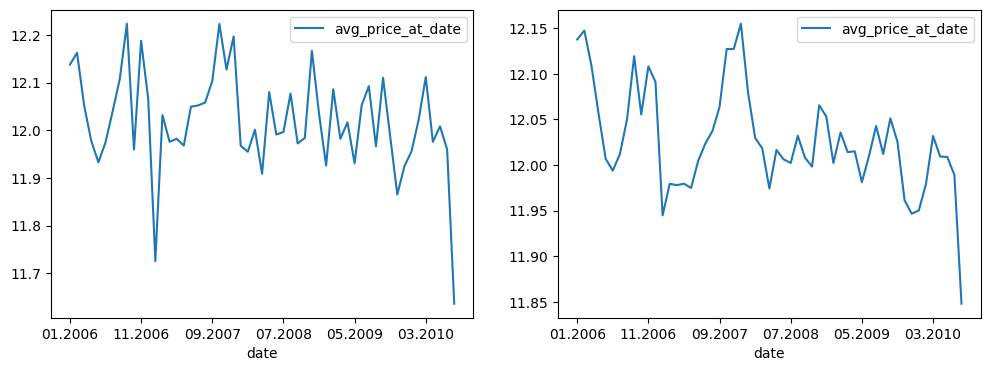

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

avg_price_at_date.plot(x='date', ax=axs[0])

avg_price_at_date_smoothed = pd.concat([avg_price_at_date['date'],
                                        avg_price_at_date['avg_price_at_date'].ewm(span=4, adjust=False).mean()], axis=1)
avg_price_at_date_smoothed.plot(x='date', ax=axs[1])

In [30]:
df['date'] = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), format='%m.%Y').dt.strftime('%m.%Y')

df = df.merge(avg_price_at_date_smoothed, how='left', on='date')
df = df.drop('date', axis=1)
df

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,avg_price_at_date
0,1,65.00,9.04,CollgCr,Norm,Norm,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03
1,2,80.00,9.17,Veenker,Feedr,Norm,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97
2,3,68.00,9.33,CollgCr,Norm,Norm,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01
3,4,60.00,9.16,Crawfor,Norm,Norm,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15
4,5,84.00,9.57,NoRidge,Norm,Norm,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,Gilbert,Norm

In [31]:
avg_price_at_neighborhood = df.groupby('Neighborhood', as_index=False)['SalePrice'].mean().rename({'SalePrice' : 'avg_price_at_neighborhood'}, axis=1)
df = df.merge(avg_price_at_neighborhood, how='left', on='Neighborhood')
df = df.drop('Neighborhood', axis=1)
df

,Id,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,avg_price_at_date,avg_price_at_neighborhood
0,1,65.00,9.04,Norm,Norm,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03,12.16
1,2,80.00,9.17,Feedr,Norm,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97,12.34
2,3,68.00,9.33,Norm,Norm,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01,12.16
3,4,60.00,9.16,Norm,Norm,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15,12.21
4,5,84.00,9.57,Norm,Norm,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05,12.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,Norm,Norm,

In [32]:
conditions = list(set(df['Condition1'].unique().tolist() + df['Condition2'].unique().tolist()))
conditions.remove('Norm')
conditions

['PosA', 'PosN', 'Feedr', 'RRNn', 'RRAe', 'RRAn', 'RRNe', 'Artery']

In [33]:
for condition in conditions:
    df[f'Condition_{condition}'] = ((df['Condition1'] == condition) | (df['Condition2'] == condition)).astype('int')

df = df.drop(['Condition1', 'Condition2'], axis=1)
df

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,avg_price_at_date,avg_price_at_neighborhood,Condition_PosA,Condition_PosN,Condition_Feedr,Condition_RRNn,Condition_RRAe,Condition_RRAn,Condition_RRNe,Condition_Artery
0,1,65.00,9.04,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03,12.16,0,0,0,0,0,0,0,0
1,2,80.00,9.17,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97,12.34,0,0,1,0,0,0,0,0
2,3,68.00,9.33,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01,12.16,0,0,0,0,0,0,0,0
3,4,60.00,9.16,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15,12.21,0,0,0,0,0,0,0,0
4,5,84.00,9.57,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05,12.63,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,6,5,1999,2000,0.00,0.00,0,59.77,953,6.86,694,0,7.41,0,0,2,1,3,1,7,1,TA,"1,999.00",2,460,0.00,3.71,0,0,0,0,0,8,20

## Data processing pipeline

I opted for my custom solution, since sklearn's Pipeline has some limitations:
* Mostly supports its own classes and methods
* Would not support your own methods (although imblearn does)
* Requires some workarounds - having to output y, even if a pipeline method has nothing to do with that (see [OneHotEncoder docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html))

In [34]:
def process_data(df:pd.DataFrame, return_saleprice:bool=True, mode:str='train') -> pd.DataFrame:
    '''
    Process data
    '''
    # OHE
    df_cats_encoded = ohencoder.transform(df[cat_cols])
    df = pd.concat([df.drop(cat_cols, axis=1), df_cats_encoded], axis=1)
    # /OHE
    
    # Handling outliers
    if mode == 'train':
        df = df.drop(outliers.index)
    # /Handling outliers
    
    # BoxCox transformation
    for col, _lambda in decided_lambdas_dict.items():
        if mode == 'test' and col == 'SalePrice':
            continue
        else:
            df[col] = boxcox(df[col]+1, _lambda)
    # /BoxCox transformation
    
    # Feature engineering
    df['date'] = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), format='%m.%Y').dt.strftime('%m.%Y')
    df = df.merge(avg_price_at_date_smoothed, how='left', on='date')
    df = df.drop('date', axis=1)
    
    df = df.merge(avg_price_at_neighborhood, how='left', on='Neighborhood')
    df = df.drop('Neighborhood', axis=1)

    for condition in conditions:
        df[f'Condition_{condition}'] = ((df['Condition1'] == condition) | (df['Condition2'] == condition)).astype('int')

    df = df.drop(['Condition1', 'Condition2'], axis=1)
    
    df['FireplaceQu'] = df['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}).astype('int')
    df['FireplaceQu*Fireplaces'] = df['Fireplaces'] * df['FireplaceQu']
    df = df.drop('FireplaceQu', axis=1)
    
    df['ageAtRemod'] = df['YrSold']-df['YearRemodAdd']
    df['ageAtSold'] = df['YrSold']-df['YearBuilt']
    
    df['SFPerRoomAboveGround'] = df['GrLivArea'] / df['TotRmsAbvGrd']
    df['TotalBathrooms'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['SF'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['TotalPorchSF'] + df['GarageArea']
    # /Feature engineering

    # Standard scaling
    for col in df.columns:
        if col == 'Id':
            continue
        elif col == 'SalePrice':
            saleprice_mean = df[col].mean()
            saleprice_std = df[col].std()
        
        df[col] = (df[col] - df[col].mean()) / df[col].std()

    # Missing value imputation
    df.loc[df['GarageYrBlt'].isna(), 'GarageYrBlt'] = df.loc[df['GarageYrBlt'].isna(), 'YearBuilt']
    
    for col in ['avg_price_at_date', 'avg_price_at_neighborhood']:
        df[col] = df[col].fillna(df[col].mean())
    
    df = df.fillna(0)
    # /Missing value imputation
    if return_saleprice:
        return df, saleprice_mean, saleprice_std
    else:
        return df


# I run both train and test data through it to ensure consistency
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

df2 = pd.read_csv('/kaggle/input/housing/AmesHousing.csv').drop('PID', axis=1)
df2.columns = df.columns

df = pd.concat([df, df2])

df, salePriceMean, salePriceStd = process_data(df, mode='train')
df_test = process_data(pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv'), return_saleprice=False, mode='test')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 5, 12, 13, 14, 18, 19, 27, 28, 34, 36, 37, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 5, 12, 13, 27, 28, 37, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Checking for validity of processing

In [35]:
[col for col in df_test.columns if col not in df.columns]

[]

In [36]:
[col for col in df.columns if col not in df_test.columns]

['SalePrice']

# Machine Learning

## ML experiments

To go:
* Stacking regressor with GridSearchCV and kfold https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
  * ElasticNet, kNN as base learners
  * Catboost as meta learner that uses input data as well

Succesful experiments:
* Kfolding
* Catboost

Unsuccesful experiments:
* Overfitting detectors for Catboost
* SVRs as standalone learner
* ElasticNet as standalone learner
* Linear combination as "meta learner"

## ML experiments

In [37]:
# kfold = KFold(n_splits=4, shuffle=True)
# kfold

### Catboost

In [38]:
# catboost = CatBoostRegressor(verbose=0, random_seed=888)
# catboost.fit(df.drop(['SalePrice', 'Id'], axis=1), df['SalePrice'])

In [39]:
# catboost.get_feature_importance(prettified=True)[20:0:-1].set_index('Feature Id').plot(kind='barh')

In [40]:
# # params = {'iterations':[800, 1000, 1200],
# #          'depth':[8, 10, 12],
# #          'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS'],
# #          'min_data_in_leaf':[2, 25, 50],
# #          'colsample_bylevel':[0.01, 0.1, 0.5, 0.9, 1]}
# # clf_grid = GridSearchCV(estimator=CatBoostRegressor(verbose=0, random_seed=888), param_grid=params, cv=4)
# # clf_grid.fit(df.drop(['SalePrice', 'Id'], axis=1), df['SalePrice'])
# # print(clf_grid.best_params_)
# catboost_best_params = {'iterations': 1200,
#     'depth': 8,
#     'bootstrap_type': 'Bernoulli',
#     'min_data_in_leaf': 2,
#     'colsample_bylevel': 0.5}

In [41]:
# catboosts = [CatBoostRegressor(verbose=0, random_seed=i, **catboost_best_params) for i in range(4)]
# catboosts_errors = []
# for i, (train, test) in enumerate(kfold.split(df)):
#     X_train, y_train = df.loc[train].drop(['SalePrice', 'Id'], axis=1), df.loc[train, 'SalePrice']
#     X_test, y_test = df.loc[test].drop(['SalePrice', 'Id'], axis=1), df.loc[test, 'SalePrice']
#     catboosts[i].fit(X_train, y_train)
#     catboosts_errors.append(mean_squared_error(y_test, catboosts[i].predict(X_test)))

# catboosts_errors = np.array(catboosts_errors)
# catboosts_errors.mean(), catboosts_errors.std()

In [42]:
# predictions = []

# for i in range(4):
#     predictions.append(catboosts[i].predict(df_test.drop('Id', axis=1)))
    
# predictions = np.expm1(np.stack(predictions).mean(axis=0))

# predictions = pd.concat([
#     df_test['Id'],
#     pd.Series(predictions, name='SalePrice')
# ], axis=1)
# predictions

In [43]:
# estimators = [('elasticnet', ElasticNet()), ('svr', LinearSVR(random_state=888, max_iter=2000, dual=False, loss='squared_epsilon_insensitive'))]

# stackingRegressor = StackingRegressor(estimators=estimators, final_estimator=CatBoostRegressor(verbose=0, random_seed=888, **{'iterations': 1200,
#     'depth': 8,
#     'bootstrap_type': 'Bernoulli',
#     'min_data_in_leaf': 2,
#     'colsample_bylevel': 0.5}), passthrough=True)

# params = {'elasticnet__l1_ratio' : [0.1, 0.5, 0.9],
#          'elasticnet__alpha' : [0.5, 1, 2],
#          'svr__C' : [0.5, 1, 2]
#          }

# grid = GridSearchCV(estimator=stackingRegressor, param_grid=params, cv=4)
# grid.fit(df.drop(['Id', 'SalePrice'], axis=1), df['SalePrice'])
# grid.best_params_

In [44]:
estimators = [('elasticnet', ElasticNet(alpha=1, l1_ratio=0.1)), ('svr', LinearSVR(C=2, random_state=888, max_iter=2000, dual=False, loss='squared_epsilon_insensitive'))]

stackingRegressor = StackingRegressor(estimators=estimators, final_estimator=CatBoostRegressor(verbose=0, random_seed=888, **{'iterations': 1200,
    'depth': 8,
    'bootstrap_type': 'Bernoulli',
    'min_data_in_leaf': 2,
    'colsample_bylevel': 0.5}), passthrough=True, cv=4)

stackingRegressor.fit(df.drop(['Id', 'SalePrice'], axis=1), df['SalePrice'])
mean_squared_error(df['SalePrice'], stackingRegressor.predict(df.drop(['Id', 'SalePrice'], axis=1)))

0.003438388340044945

In [45]:
predictions = stackingRegressor.predict(df_test.drop('Id', axis=1))
predictions = predictions*salePriceStd + salePriceMean
predictions = np.expm1(predictions)
predictions = pd.Series(predictions, name='SalePrice')
predictions = pd.concat([df_test['Id'], predictions], axis=1)
predictions

,Id,SalePrice
0,1461,"115,015.19"
1,1462,"174,231.75"
2,1463,"189,486.64"
3,1464,"200,316.85"
4,1465,"185,193.85"
...,...,...
1454,2915,"89,875.29"
1455,2916,"80,497.29"
1456,2917,"134,628.86"
1457,2918,"130,284.75"


In [46]:
predictions.to_csv('submission.csv', index=False)